In [20]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from tqdm.notebook import tqdm
import albumentations as A

# from ipywidgets import IntProgress
import multiprocessing
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
import seaborn as sns

from torchvision.ops import batched_nms
import mmcv

from ensemble_boxes import *

from matplotlib.pyplot import imshow
from PIL import Image

from torchvision.ops import box_iou

/home/usrg/miniconda3/envs/robert3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [74]:
def plot_image(img_path, boxes, labels):
    
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    image = image.astype('float32')
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
        { 'id':14, 'name': 'No finding'},
    ] 
    
    plt.figure(figsize=(16,16))
    
    for box,label in zip(boxes, labels):
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (225,0,0), 4)
        label = categories[label]['name'].upper()
        print(label, box)
        cv2.putText(image, 
                    label,
                    (box[0], box[1]), 
                    fontFace = cv2.FONT_HERSHEY_COMPLEX, 
                    fontScale = 1,
                    color = (255, 0, 0),
                    thickness = 2,
                    lineType = cv2.LINE_AA
                   )
    plt.imshow(image)

In [48]:
df = pd.read_csv('10_fold_dedub_abnormal_org_size.csv')
# df = pd.read_csv('train.csv')
# abnormal = df[df.class_id != 14].groupby('image_id').agg(lambda x: list(x)).reset_index()

# fold_id = 0
# train_df = df[df.fold_id != fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()

# fold_id = 1
# valid_df = df[df.fold_id == fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()

meta = pd.read_csv('train_meta.csv').set_index('image_id')
# fold_id = 1
# train_df = df[df.fold_id != fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()
# valid_df = df[df.fold_id == fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()

d = df[(df.class_id == 7) | (df.class_id == 6)].groupby('image_id').agg(lambda x: list(x)).reset_index()

In [78]:
def remove_dublicates(df, output_file):
 
    n = len(df)
   
    df_annotations = []
    iou_thr = 0.01
  
    for idx in tqdm(range(n)):

        records = df.loc[idx]
        image_id = records['image_id']

        width = meta.loc[image_id]['dim1']
        height = meta.loc[image_id]['dim0']
        
        labels = records['class_id']
        scores = np.ones(len(labels))
        
        boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
        boxes = np.array(boxes.tolist()).T
        boxes = boxes.astype(int)
        
        boxes = boxes.astype(float)
        boxes[:, 0] = boxes[:, 0] / width
        boxes[:, 2] = boxes[:, 2] / width
        boxes[:, 1] = boxes[:, 1] / height
        boxes[:, 3] = boxes[:, 3] / height

        scores = np.ones(len(labels))

#         filtering dublicates from multiple radiologists 
        boxes, scores, labels = nms([boxes], [scores], [labels], iou_thr=iou_thr)

        boxes[:, 0] = boxes[:, 0] * width
        boxes[:, 2] = boxes[:, 2] * width
        boxes[:, 1] = boxes[:, 1] * height
        boxes[:, 3] = boxes[:, 3] * height
        
        boxes = boxes.astype(int)
        
        labels = labels.astype(int)
        
#         img_path = 'train_2x/train/' + image_id + '.jpg'
#         print(image_id)
#         plot_image(img_path, boxes, labels, scores)

        for i in range(len(boxes)):

            label = labels[i]

            bbox = boxes[i]
            area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
                
            box_anno = dict(
                image_id=image_id,
                class_id=label,
                x_min=bbox[0],
                y_min=bbox[1],
                x_max=bbox[2],
                y_max=bbox[3],
                area=area,
                width=width,
                height=height)

            df_annotations.append(box_anno)
            
    d = pd.DataFrame(df_annotations)
    d.to_csv(output_file, index=False)
            

remove_dublicates(abnormal, 'abnormal_dedub_org_size.csv')

  0%|          | 0/4394 [00:00<?, ?it/s]

In [37]:
df = pd.read_csv('5_fold_dedub_abnormal_org_size.csv')

fold_id = 0
meta = pd.read_csv('train_meta.csv').set_index('image_id')

train_df = df[df.fold_id != fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()
valid_df = df[df.fold_id == fold_id].groupby('image_id').agg(lambda x: list(x)).reset_index()
full_df = df.groupby('image_id').agg(lambda x: list(x)).reset_index()
# ax = sns.countplot(x="class_id",data=df)

In [88]:
def iou_score(a, b):
    
    w_1 = a[2]-a[0]
    h_1 = a[3]-a[1]

    w_2 = b[2]-b[0]
    h_2 = b[3]-b[1]
    
    a_1 = w_1*h_1
    a_2 = w_2*h_2
    
    xx1 = np.maximum(a[0], b[0])
    yy1 = np.maximum(a[1], b[1])
    xx2 = np.minimum(a[2], b[2])
    yy2 = np.minimum(a[3], b[3])

    w = np.maximum(0.0, xx2 - xx1)
    h = np.maximum(0.0, yy2 - yy1)
    inter = w * h
    ovr = inter / (a_1 + a_2 - inter)
    
    return ovr

  0%|          | 0/4394 [00:00<?, ?it/s]

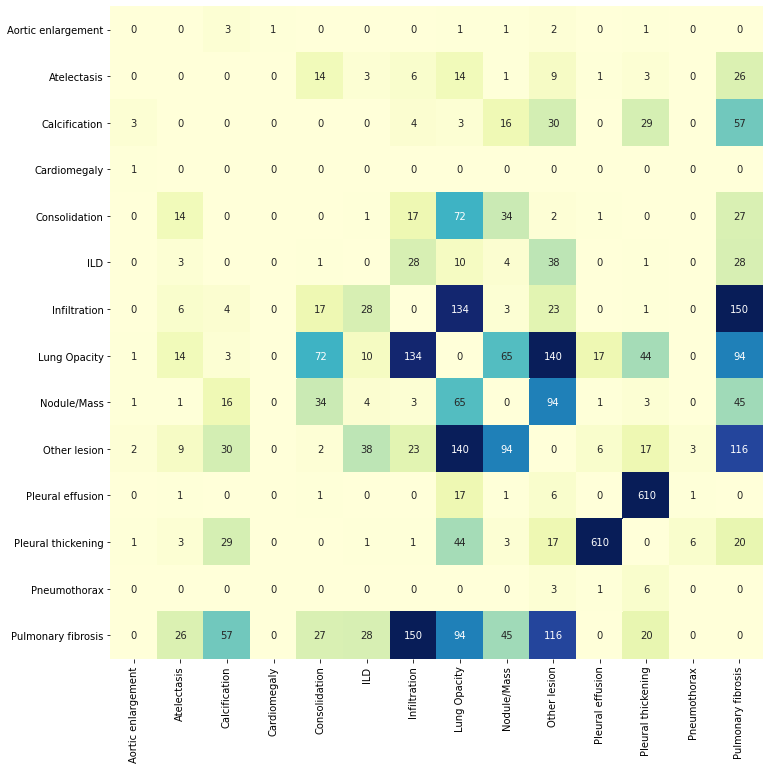

In [138]:
def find_bad_images(df, output_file):
 
    n = len(df)
    
    large_thr = 0.8
    iou_thr = 0.9999
    
    bad_ids = []
    
    class_overlap = np.zeros((14,14)).astype(int)

    for idx in tqdm(range(n)):

        records = df.loc[idx]
        image_id = records['image_id']

        width = meta.loc[image_id]['dim1']
        height = meta.loc[image_id]['dim0']
        
        labels = records['class_id']
        scores = np.ones(len(labels))
        
        boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
        boxes = np.array(boxes.tolist()).T
        boxes = boxes.astype(int)

        
        overlaps = np.zeros((len(boxes), len(boxes)))
    
        for i in range(len(boxes)):

            label = labels[i]
            bbox = boxes[i]
            
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            
            box_overlaps = []
            
            for j in range(len(boxes)):
                
                if i != j:
                    iou = iou_score(bbox, boxes[j])
                    
                    if iou >= iou_thr and label != labels[j]:
                        
                        overlaps[i,j] = 1
    
                        class_overlap[label, labels[j]] += 1
    
                        bad_ids.append(dict(
                            image_id=image_id,
                            type='overlap'
                        ))
            
            if w >= width*large_thr:
                bad_ids.append(dict(
                    image_id=image_id,
                    type='large'
                ))
                
        overlaps = np.triu(overlaps) 
        
        checked = {}
        
        clean = {}
        
        for i in range(len(overlaps)):
             
            if i in checked:
                continue 
            
            row = overlaps[i].flatten()
            overlapping_ids = np.argwhere(row == 1).flatten().tolist()
            
            if len(overlapping_ids) > 0:

                clean[i] = overlapping_ids

                checked[i] = 1

                for box_idx in overlapping_ids:
                    checked[box_idx] = 1
            else:
                clean[i] = []

#         if len(clean) > 0:
#             print(image_id, clean)
    
    d = pd.DataFrame(bad_ids)
    d = d.drop_duplicates()
    d.to_csv(output_file, index=False)      
    
#     print(np.triu(class_overlap).astype(int))
    hm = class_overlap
#     hm = np.triu(hm).astype(int)
    
    classes = (
    "Aortic enlargement", 
    "Atelectasis", 
    "Calcification", 
    "Cardiomegaly", 
    "Consolidation", 
    "ILD", 
    "Infiltration", 
    "Lung Opacity", 
    "Nodule/Mass", 
    "Other lesion", 
    "Pleural effusion", 
    "Pleural thickening", 
    "Pneumothorax", 
    "Pulmonary fibrosis")

    
    fig, ax = plt.subplots(figsize=(12,12)) 
    f = sns.heatmap(hm, square=True, robust=True, annot=True, cbar=False, xticklabels=classes, yticklabels=classes, fmt="d", cmap="YlGnBu")
    f.figure.savefig("cm.jpg")
find_bad_images(full_df, 'bad.csv')

11    3329
0     3073
13    2543
3     2313
7     1714
8     1695
9     1581
10    1282
6      840
2      652
5      624
4      395
1      198
12     111
Name: class_id, dtype: int64

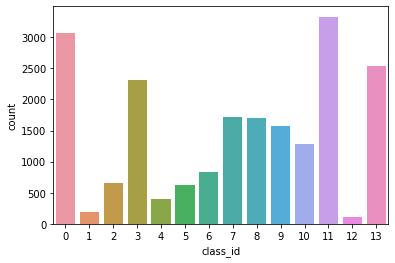

In [135]:
dedub = pd.read_csv('5_fold_dedub_abnormal_org_size.csv')
ax = sns.countplot(x="class_id",data=dedub)
dedub.class_id.value_counts()

In [76]:
def generate_data_json(df, output_file):
    
    categories = [
        { 'id':0, 'name': 'Aortic enlargement'},
        { 'id':1, 'name': 'Atelectasis'},
        { 'id':2, 'name': 'Calcification'},
        { 'id':3, 'name': 'Cardiomegaly'},
        { 'id':4, 'name': 'Consolidation'},
        { 'id':5, 'name': 'ILD'},
        { 'id':6, 'name': 'Infiltration'},
        { 'id':7, 'name': 'Lung Opacity'},
        { 'id':8, 'name': 'Nodule/Mass'},
        { 'id':9, 'name': 'Other lesion'},
        { 'id':10, 'name': 'Pleural effusion'},
        { 'id':11, 'name': 'Pleural thickening'},
        { 'id':12, 'name': 'Pneumothorax'},
        { 'id':13, 'name': 'Pulmonary fibrosis'},
    ] 
    
    n = len(df)

    annotations = []
    images = []
    
    obj_count = 0

    for idx in tqdm(range(n)):

        records = df.loc[idx]
        image_id = records['image_id']
        
        width = meta.loc[image_id]['dim1'] 
        height = meta.loc[image_id]['dim0']
    
        images.append(dict(
            id=idx,
            file_name=image_id + '.jpg',
            height=height,
            width=width))
 
        boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
        boxes = np.array(boxes.tolist()).T
        boxes = boxes.astype(int)
        labels = records['class_id']
        
#         for i in len(boxes):
            
#             box_1 = boxes[i]
            
#             for j in len(boxes):
                
#                 box_2 = boxes[j]
                
#                 iou = box_iou(box_1, box_2)

#                 if iou > 0.2 and labels[i] == labels[j]:
#         scores = np.ones(len(labels))
#         img_path = 'vinbigdata/train/' + image_id + '.jpg'
#         plot_image(img_path, boxes, labels)        
          
        for i in range(len(boxes)):

            label = labels[i]
#             print(categories[label])
            bbox = boxes[i]
            area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
            
#             if bbox[2] - bbox[0] > width * 0.6:
#                 continue
            
            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=label,
                bbox=[bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]],
                area=area,
                iscrowd=0)
            
            annotations.append(data_anno)
            
            obj_count += 1
    
    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=categories)
    mmcv.dump(coco_format_json, output_file)

In [82]:
generate_data_json(train_df, 'fold_0_abnormal_train_org_size.json')

  0%|          | 0/3959 [00:00<?, ?it/s]

In [83]:
generate_data_json(valid_df, 'fold_0_abnormal_valid_org_size.json')

  0%|          | 0/435 [00:00<?, ?it/s]

1438
0
AORTIC ENLARGEMENT [1347  468 1675  849]
CARDIOMEGALY [ 818 1053 1913 1340]
LUNG OPACITY [1932 1114 2203 1231]
OTHER LESION [1129  302 1347  844]
PLEURAL EFFUSION [ 254 1261  402 1434]
PLEURAL EFFUSION [2054 1112 2282 1329]
PLEURAL THICKENING [ 209 1199  552 1396]
PLEURAL THICKENING [2054 1112 2282 1329]
PULMONARY FIBROSIS [1932 1114 2203 1231]
PULMONARY FIBROSIS [ 629 1185  821 1265]
00150343289f317a0ad5629d5b7d9ef9


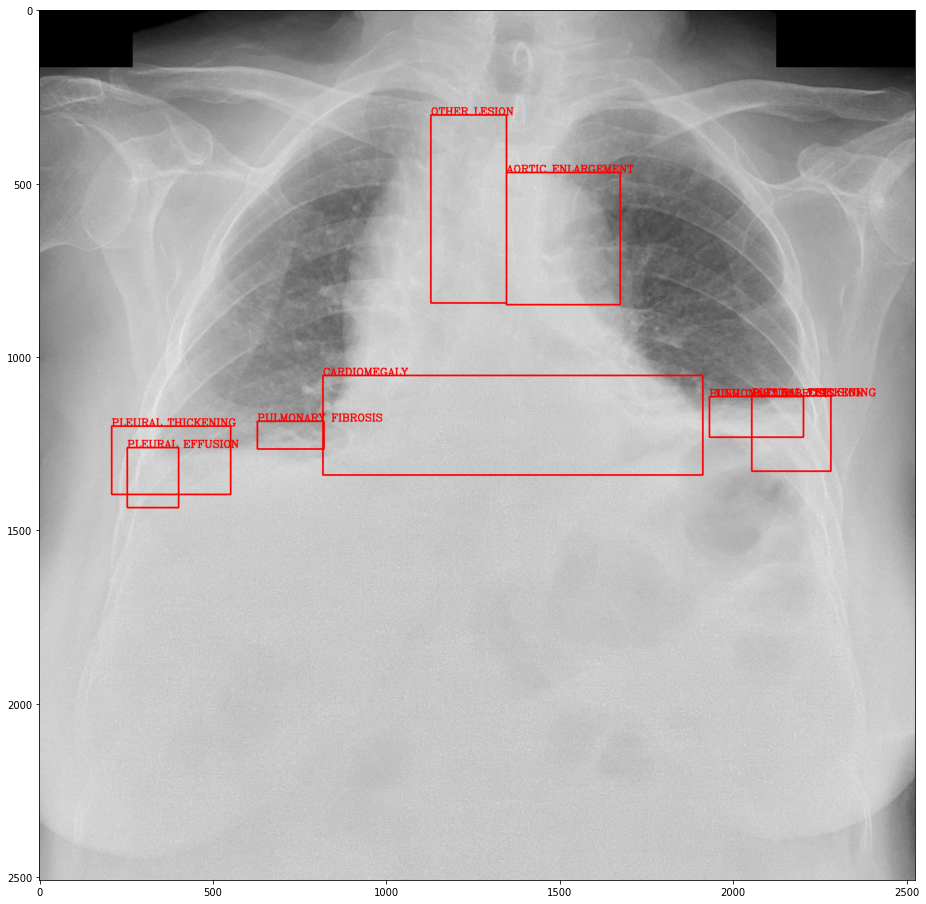

In [113]:
bad = pd.read_csv('bad.csv')

df = pd.read_csv('5_fold_dedub_abnormal_org_size.csv').groupby('image_id').agg(lambda x: list(x)).reset_index()
df = df.set_index('image_id')

print(len(bad.groupby('image_id')))
print(len(bad[bad.type == 'large']))
idx = 3

image_id = bad.loc[idx - 1]['image_id']
records = df.loc[image_id]

img_path = 'vinbigdata/images/train/' + image_id + '.jpg'


boxes = records[['x_min','y_min', 'x_max', 'y_max']].to_numpy()
boxes = np.array(boxes.tolist()).T
labels = records['class_id']
scores = np.ones(len(labels))

plot_image(img_path, boxes, labels)
print(image_id)

In [42]:
test_df = pd.read_csv('test.csv')
categories = [
    { 'id':0, 'name': 'Aortic enlargement'},
    { 'id':1, 'name': 'Atelectasis'},
    { 'id':2, 'name': 'Calcification'},
    { 'id':3, 'name': 'Cardiomegaly'},
    { 'id':4, 'name': 'Consolidation'},
    { 'id':5, 'name': 'ILD'},
    { 'id':6, 'name': 'Infiltration'},
    { 'id':7, 'name': 'Lung Opacity'},
    { 'id':8, 'name': 'Nodule/Mass'},
    { 'id':9, 'name': 'Other lesion'},
    { 'id':10, 'name': 'Pleural effusion'},
    { 'id':11, 'name': 'Pleural thickening'},
    { 'id':12, 'name': 'Pneumothorax'},
    { 'id':13, 'name': 'Pulmonary fibrosis'},
] 
images = []
for i in range(len(test_df)):
    r = test_df.iloc[i]
    image_id = r['image_id']
    images.append(dict(
        id=i,
        file_name=image_id + '.jpg',
        height=r['height'],
        width=r['width']))
coco_format_json = dict(
    images=images,
    categories=categories)
mmcv.dump(coco_format_json, 'test_coco_org.json')

In [1]:
%load_ext tensorboard

In [5]:
%tensorboard --logdir checkpoints_1024_fold_0/tf_logs --port=6008

Reusing TensorBoard on port 6008 (pid 700), started 0:00:12 ago. (Use '!kill 700' to kill it.)